In [71]:
#Librerias
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from datetime import datetime
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 10]

In [72]:
data=pd.read_csv("demanda.csv", index_col='TIPO', parse_dates=True)
display(data.head(5), data.dtypes)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2013-01-01,4538446.146,3319300.732,3276372.467,1.113412e+07
2013-02-01,3961686.119,2820263.212,3052210.676,9.834160e+06
2013-03-01,3612835.111,2861328.931,3281965.266,9.756129e+06
2013-04-01,3239380.702,2826797.310,3241156.151,9.307334e+06
2013-05-01,3919668.996,2948663.278,3364493.120,1.023283e+07


Residencial                    float64
Comercial                      float64
Industrial/Comercial Grande    float64
TOTAL                          float64
dtype: object

In [73]:
data.describe().round(1)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,79.0,79.0,79.0,79.0
mean,4551935.3,3113096.4,3187977.0,10853008.7
std,654164.9,206830.0,124659.7,816874.8
min,3239380.7,2809183.1,2897618.7,9307334.2
25%,3990580.4,2948084.1,3109179.2,10223259.4
50%,4470715.1,3070853.2,3199317.2,10706955.3
75%,5092450.5,3270751.9,3275571.6,11476365.0
max,6193110.2,3606989.1,3460880.0,12607552.7


In [74]:
resi= data["Residencial"].copy()
resi.index= resi.index.to_period(freq="M")
comm=data["Comercial"].copy()
comm.index= comm.index.to_period(freq="M")
ts_c= data["Comercial"]
ts_r= data["Residencial"]

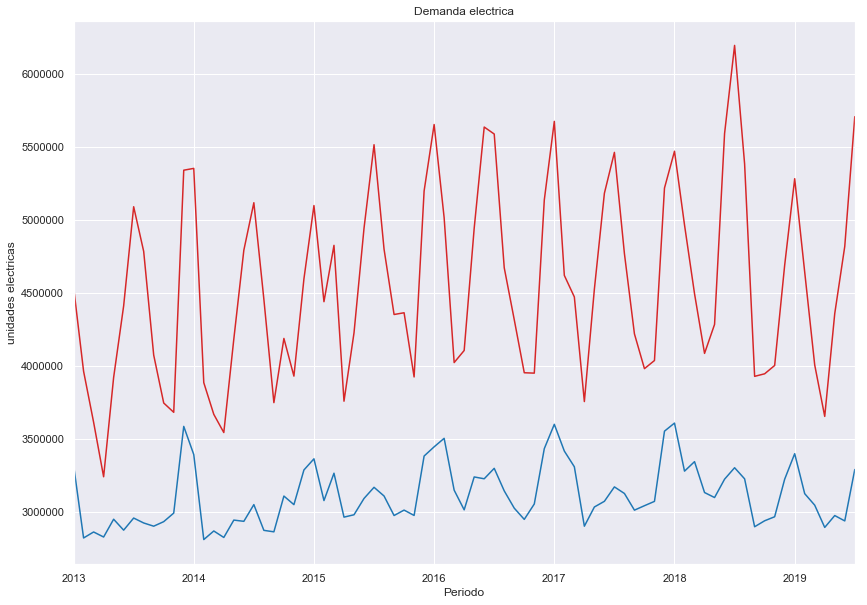

In [75]:
azul= "#1F77B4"
rojo= "#D62728"
sns.set()
fig, ax=plt.subplots()
resi.plot(color= rojo)
comm.plot(color= azul)
ax.set_xlabel("Periodo")
ax.set_ylabel("unidades electricas")
plt.title("Demanda electrica")
plt.show()

### Implementacion de ARIMA

In [21]:
import os
PATH=r'C:\Users\gasto\Desktop\Series temporales\WinX13\x13as'
os.chdir(PATH)

In [22]:
decomposition_r = sm.tsa.x13_arima_analysis(ts_r,x12path='.') #Descomposicion para Residenciales

In [23]:
decomposition_c = sm.tsa.x13_arima_analysis(ts_c,x12path='.') #Descomposicion para Comerciales

In [25]:
[attr for attr in dir(decomposition_c) if not attr.startswith('_')] #Verificamos las salidas

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

In [26]:
[attr for attr in dir(decomposition_r) if not attr.startswith('_')] #Verificamos las salidas

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

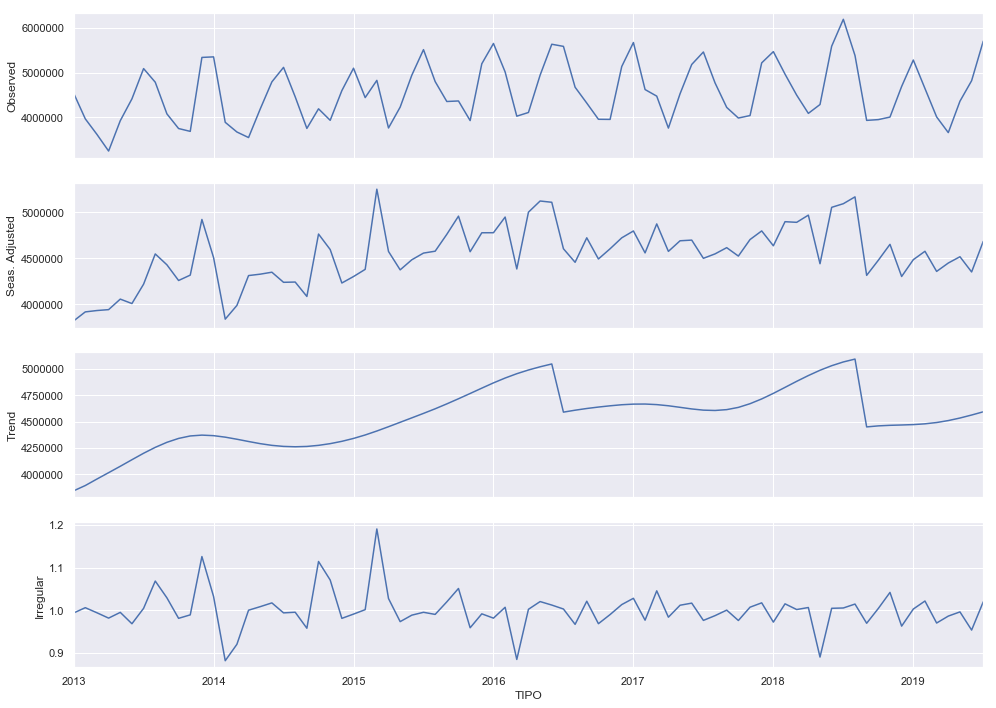

In [76]:
#Graficamos la descomposición
sns.set()
decomposition_r.plot()
plt.show()

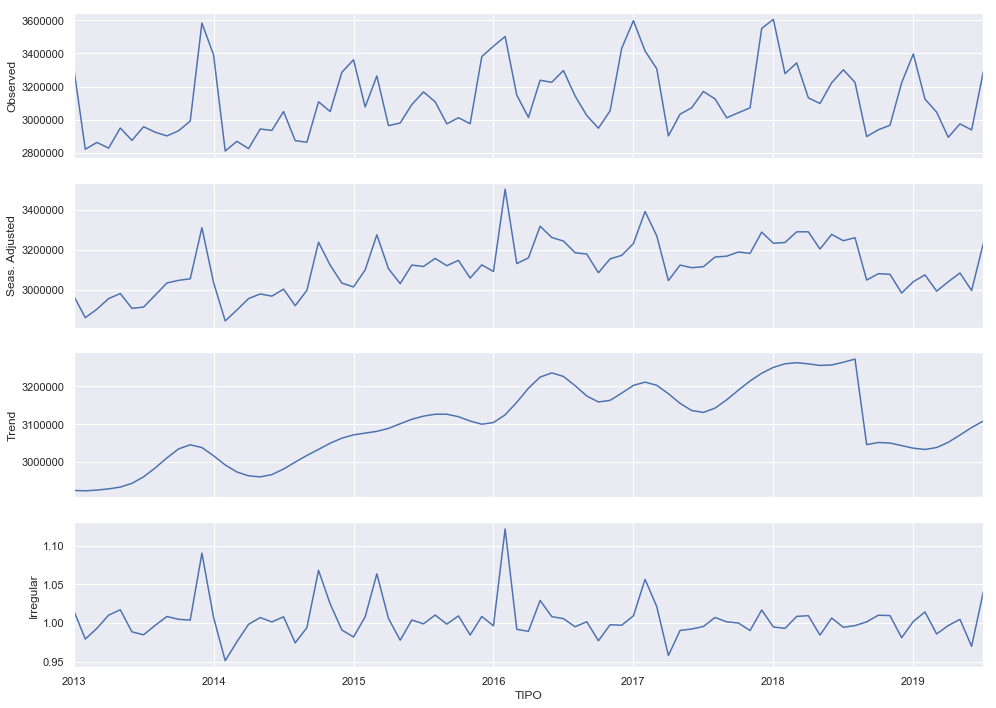

In [77]:
#Graficamos la descomposición

decomposition_c.plot()
plt.show()


In [39]:
import io
PATH=r"C:\Users\gasto\Desktop\Series temporales" #Bbusco la funcion de graficar lindo
os.chdir(PATH)


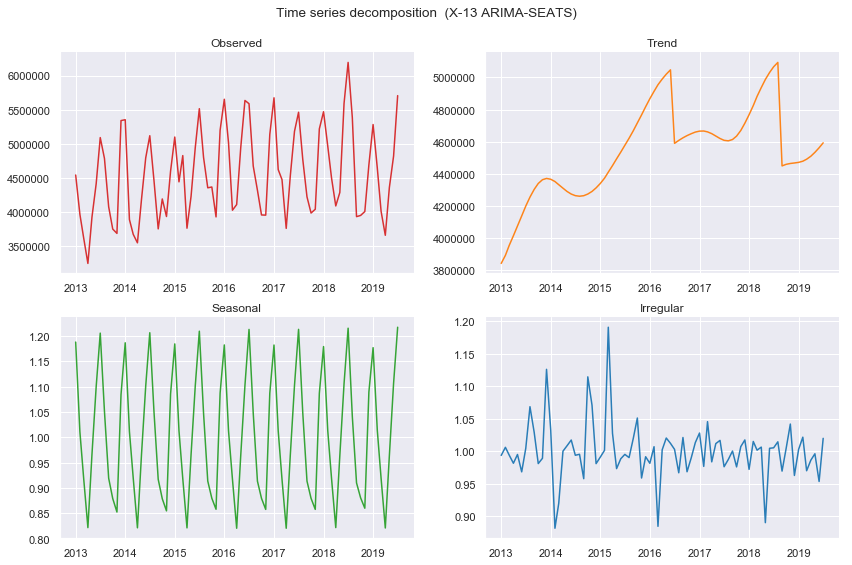

In [78]:
#Una Grafica mas amable
from plotting import plot_components_x13
plot_components_x13(decomposition_r)
plt.show()


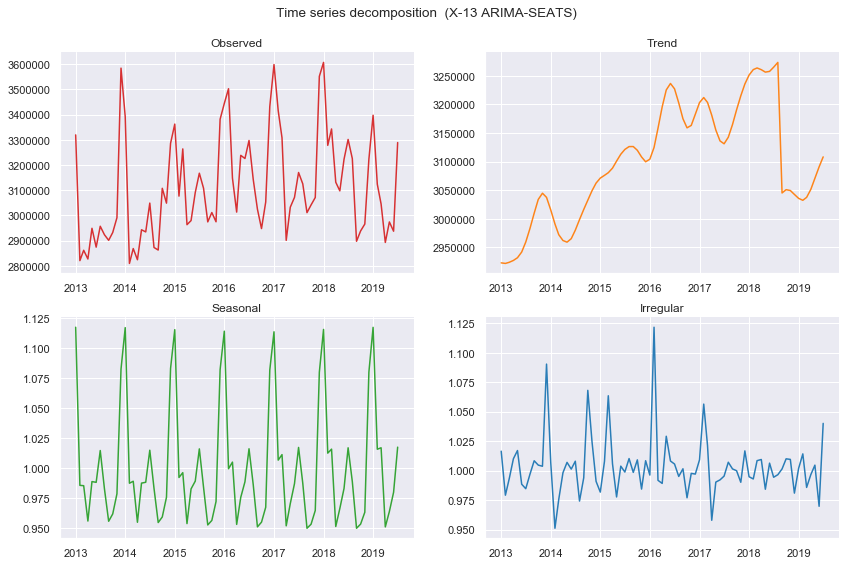

In [79]:
from plotting import plot_components_x13
plot_components_x13(decomposition_c)
plt.show()

### - HOLT WINTERS

#### Vamos a mapear diferentes configuraciones de fitting para ver cual ajusta mejor. 

In [54]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [55]:
#Me voy a quedar solamente con Residenciales por simplicidad, lo podria escalar a Comecriales y totales despues.
ahw_sm=sm.tsa.ExponentialSmoothing(resi, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
mhw_sm=sm.tsa.ExponentialSmoothing(resi, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
mhw_damped=sm.tsa.ExponentialSmoothing(resi, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()

In [56]:
ahw_sm=sm.tsa.ExponentialSmoothing(resi, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
resumen_hw(ahw_sm)#; resumen_hw(mhw_sm); resumen_hw(mhw_damped))

 In-sample fit:
 RMSE               324969.205


#### Duda de no computologo- No me entrega los reportes completos

In [51]:
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               324969.205


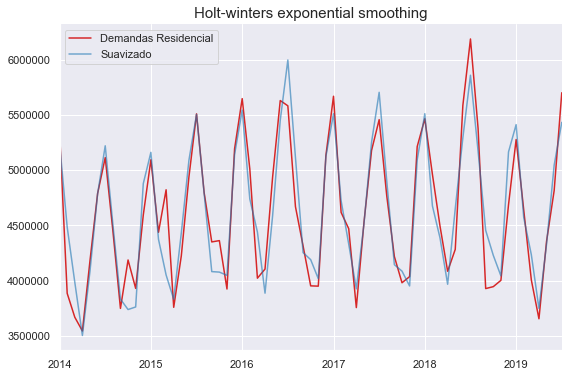

In [80]:
sns.set()
smoothed=pd.Series(mhw_sm.fittedvalues, index=resi.index)

fig, ax= plt.subplots(figsize=(9,6));

resi['2014':].plot(color= rojo, label='Demandas Residencial')
smoothed['2014':].plot(color=azul, label='Suavizado', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=15)
sns.despine()
plt.show()

### Validacion :
Se van a comparar las 3 configuraciones de ajustes con la "medicion"

In [82]:
start_val_r = resi.index[-round(len(resi)/12*.6)*12]
start_val_r

Period('2015-08', 'M')

In [83]:
y=resi


C:\Users\gasto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)


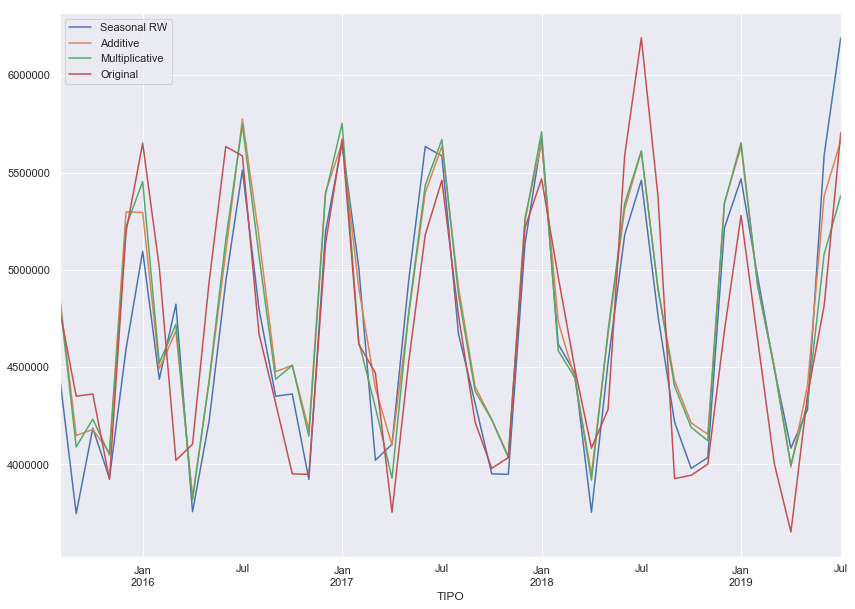

In [84]:
# A la pprediccion de residenciales solamente, puedo escalarlo a todos

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Original']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)
results.plot();